<a href="https://colab.research.google.com/github/kamalova/Capstone/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
import string
string.punctuation
import re
from sklearn.feature_extraction.text import TfidfVectorizer


# Data visualization
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
# Seaborn's beautiful styling
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px
# to get rid of the warnings
import warnings
warnings.filterwarnings("ignore")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud

In [3]:
%rm -rf sample_data/

In [4]:

reviews_march = pd.read_csv('/content/reviews_march.csv', compression='gzip', on_bad_lines='skip',
                       low_memory=False, nrows=20000);
reviews_jun = pd.read_csv('/content/reviews_jun.csv', compression='gzip', on_bad_lines='skip',
                       low_memory=False, nrows=20000);
reviews_sep = pd.read_csv('/content/reviews_sep.csv', compression='gzip', on_bad_lines='skip',
                       low_memory=False, nrows=20000);
reviews_dec = pd.read_csv('/content/reviews_dec21.csv', compression='gzip', on_bad_lines='skip',
                       low_memory=False, nrows=20000);

In [159]:
print(reviews_march.shape, reviews_jun.shape, reviews_sep.shape, reviews_dec.shape)
      

(20000, 6) (20000, 6) (20000, 6) (20000, 6)


In [160]:
# Concatinate Reviews from each quarter
df_reviews = pd.concat([reviews_march,reviews_jun, reviews_sep,reviews_dec])

In [161]:

df_reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,2009-11-21,50679,Jean,"Notre séjour de trois nuits.\r<br/>Nous avons apprécier L'appartement qui est très bien situé. Agréable, propre et bien soigné. C'est idéal pour une famille de 3 ou 4 personnes.\r<br/>Petits soucis en arrivant il y avait personne pour nous recevoir, et il manquait le savon pour la douche, le liquide vaisselle, nous les avons reçu de surlendemain. Il y a aussi le bruit du Métro de NY, donc une première nuit difficile si on est pas habitué. Jennifer est correcte le remboursement de la caution était très rapide. A part ces petits détails notre court séjour c'est bien passé. \r<br/>Si j'ai la possibilité de revenir sur NY pour les vacances, je reprendrai à ""The Midtown Castle""\r<br/>Jean\r<br/>Possession - Ile de La Réunion\r<br/>"
1,2595,19176,2009-12-05,53267,Cate,Great experience.
2,2595,19760,2009-12-10,38960,Anita,"I've stayed with my friend at the Midtown Castle for six days and it was a lovely place to be. A big spacious room with a pointy roof, which really makes you feel like staying in a castle. The location is perfect. It is just a few steps from Macy's Time Square and Theatre District. Everything worked just perfect with the keys etc. Thank you so much Jennifer, we had a great time in New York.\r<br/>Attention: it's on the 4th floor without a lift :-) but definetely worth it!"
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, enjoying to be in the center of the city, that never sleeps...short ways to everywhere in Manhattan, by subway or by walk. Midtown castle is a beauftiful and tastful place, Jennifer and Tori relaxed and friendly hosts - thats why we - the three Berliners - recommand that place! Good to have WiFi and a little kitchen too!"
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming apartment! They were very organized and helpful; I would definitely recommend staying at the Midtown Castle!
...,...,...,...,...,...,...
19995,72265,161050979,2017-06-16,109542482,John,Vanessa was very pleasant and communication was very good.
19996,72265,163401732,2017-06-24,1282541,Sofia,Great location! Close to G train.
19997,72265,252657179,2018-04-11,8936723,Yo,"Highly recommend. Cannot beat this value. <br/><br/>Great location - 4 minute walk to subway and 20 sec to bus which connects you easily and quickly to various parts of Manhattan and Brooklyn. Organic (as well as regular) grocery stores and lots of awesome restaurants and stores near by. Very safe neighborhoods <br/>Nice room - not big but it's plenty enough and everything works well. It's nice & warm in the winter. Even though the bedroom is separated by a curtain to the kitchen, because the host is mainly in the other section of the apartment, you have a lot of privacy. <br/>Vanessa is a very friendly, interesting and helpful host."
19998,72265,277084426,2018-06-15,17160406,Ioannis,"Vanessa is a great and very polite host and gives you as much privacy as you want. The room can be seen in the photos and has everything you need. The location is amazing as well with plenty of bars, restaurants and stores around and literally half a block away from G train."


In [162]:
df_reviews = df_reviews.drop(columns=['id','reviewer_name'])


In [163]:
df_reviews.isnull().sum()

listing_id     0
date           0
reviewer_id    0
comments       6
dtype: int64

#### Preprocessing *Comments* for Sentiment Analysis

In [164]:
df_reviews.dropna(subset =['comments'],how='any',axis=0,inplace=True)

In [40]:
! pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
# Import language detect
from langdetect import detect

In [165]:
# Detect the language of the comments
def detect_lang(x):
    try:
        lang = detect(x)
    except:
        lang = 'other'
    return lang

df_reviews['language'] = df_reviews['comments'].apply(detect_lang)

In [80]:
# Preview frist 5 rows of dataframe
df_reviews

,listing_id,date,reviewer_id,comments,language
0,2595,2009-11-21,50679,"Notre séjour de trois nuits.\r<br/>Nous avons apprécier L'appartement qui est très bien situé. Agréable, propre et bien soigné. C'est idéal pour une famille de 3 ou 4 personnes.\r<br/>Petits soucis en arrivant il y avait personne pour nous recevoir, et il manquait le savon pour la douche, le liquide vaisselle, nous les avons reçu de surlendemain. Il y a aussi le bruit du Métro de NY, donc une première nuit difficile si on est pas habitué. Jennifer est correcte le remboursement de la caution était très rapide. A part ces petits détails notre court séjour c'est bien passé. \r<br/>Si j'ai la possibilité de revenir sur NY pour les vacances, je reprendrai à ""The Midtown Castle""\r<br/>Jean\r<br/>Possession - Ile de La Réunion\r<br/>",fr
1,2595,2009-12-05,53267,Great experience.,ro
2,2595,2009-12-10,38960,"I've stayed with my friend at the Midtown Castle for six days and it was a lovely place to be. A big spacious room with a pointy roof, which really makes you feel like staying in a castle. The location is perfect. It is just a few steps from Macy's Time Square and Theatre District. Everything worked just perfect with the keys etc. Thank you so much Jennifer, we had a great time in New York.\r<br/>Attention: it's on the 4th floor without a lift :-) but definetely worth it!",en
3,2595,2010-04-09,71130,"We've been staying here for about 9 nights, enjoying to be in the center of the city, that never sleeps...short ways to everywhere in Manhattan, by subway or by walk. Midtown castle is a beauftiful and tastful place, Jennifer and Tori relaxed and friendly hosts - thats why we - the three Berliners - recommand that place! Good to have WiFi and a little kitchen too!",en
4,2595,2010-05-25,117113,We had a wonderful stay at Jennifer's charming apartment! They were very organized and helpful; I would definitely recommend staying at the Midtown Castle!,en
...,...,...,...,...,...
19995,72265,2017-06-16,109542482,Vanessa was very pleasant and communication was very good.,en
19996,72265,2017-06-24,1282541,Great location! Close to G train.,en
19997,72265,2018-04-11,8936723,"Highly recommend. Cannot beat this value. <br/><br/>Great location - 4 minute walk to subway and 20 sec to bus which connects you easily and quickly to various parts of Manhattan and Brooklyn. Organic (as well as regular) grocery stores and lots of awesome restaurants and stores near by. Very safe neighborhoods <br/>Nice room - not big but it's plenty enough and everything works well. It's nice & warm in the winter. Even though the bedroom is separated by a curtain to the kitchen, because the host is mainly in the other section of the apartment, you have a lot of privacy. <br/>Vanessa is a very friendly, interesting and helpful host.",en
19998,72265,2018-06-15,17160406,"Vanessa is a great and very polite host and gives you as much privacy as you want. The room can be seen in the photos and has everything you need. The location is amazing as well with plenty of bars, restaurants and stores around and literally half a block away from G train.",en


In [44]:
# Count total language of all dataframe
df_reviews.language.value_counts()

en       71650
fr        3053
es        2070
de        1009
it         494
pt         320
nl         250
zh-cn      150
ja         138
ko         109
other       90
sv          82
ro          79
ru          78
af          51
no          49
da          48
so          37
ca          32
zh-tw       28
pl          26
fi          21
cy          21
tl          19
cs          19
id          12
sw          12
hu          10
tr           9
hr           7
he           6
el           5
bg           4
th           3
et           1
sl           1
vi           1
Name: language, dtype: int64

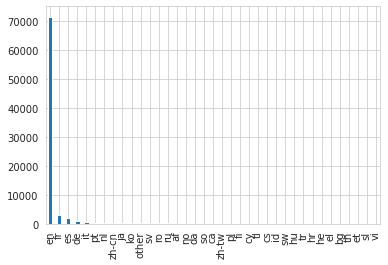

In [45]:
# Plot language column
df_reviews['language'].value_counts().plot.bar();


In [18]:
# Sample of French language
df_reviews.loc[df_reviews['language']=='fr']

,listing_id,date,reviewer_id,comments,language
0,2595,2009-11-21,50679,"Notre séjour de trois nuits.\r<br/>Nous avons apprécier L'appartement qui est très bien situé. Agréable, propre et bien soigné. C'est idéal pour une famille de 3 ou 4 personnes.\r<br/>Petits soucis en arrivant il y avait personne pour nous recevoir, et il manquait le savon pour la douche, le liquide vaisselle, nous les avons reçu de surlendemain. Il y a aussi le bruit du Métro de NY, donc une première nuit difficile si on est pas habitué. Jennifer est correcte le remboursement de la caution était très rapide. A part ces petits détails notre court séjour c'est bien passé. \r<br/>Si j'ai la possibilité de revenir sur NY pour les vacances, je reprendrai à ""The Midtown Castle""\r<br/>Jean\r<br/>Possession - Ile de La Réunion\r<br/>",fr
123,5178,2010-08-18,118953,"chambre tres bien située, du bruit mais c'est normal on est en plein Manhatan. Le propriétaire est tres discret je vous le recommande tres bonne adresse",fr
149,5178,2011-03-08,311594,"Première fois à New York et très bon séjour ! L'appartement de Shun est vraiment bien situé, à proximité de tout et la chambre est plutôt grande et confonrtable. De plus le métro est à côté donc c'est également très pratique pour aller dans les lieux à visiter qui n'étaient pas proche. Times Square et Central park à côté ! Et enfin Shun est vraiment très gentil et discret. Il était là si nous avions des questions. Encore merci à lui pour ce très bon séjour, nous recommandons cet hébergement, si nous devons retourner à New York nous choisirons encore son appartement !",fr
200,5178,2012-04-16,1337014,"Nous avons séjourné une semaine chez Shun. Grande chambre très propre et bien équipée (frigo, micro-onde, bureau, ordinateur et wifi, étagère, grand placard...).\r<br/>Shun a été très attentif à ce que nous manquions de rien tout en étant très discret. Nous l'avons très peu vu car nous rentrions souvent tard. Nous recommandons cette chambre.",fr
229,5178,2013-01-19,3768630,"La chambre était confortable bien que dépouillé de toutes décorations, surtout l'emplacement est idéal, proche des stations de métro et de broadway. \r<br/>Shun est un hote discret mais disponible",fr
...,...,...,...,...,...
19636,68974,2017-01-02,71309926,"Idéalement placé, au carrefour de Soho, Little Italie, Chinatown. Boutiques pour les filles, resto pour le soir et à 100 mètres du métro!<br/>Logement très agréable, bien équipé ( cuisine, ordinateur a dispo etc....) et bien chauffé dans lequel on se sent bien. Pas particulièrement bruyant car au 4eme étage (et je suis de la campagne donc je suis sensible au bruit).<br/>Alicia très arrangeante quant aux horaires d'arrivée (22h) et de départ(19h), très réactive par sms ou mails si on a des questions.<br/>Nous étions 7 (2 couples avec enfants) et avons été, grands et petits, super contents de retrouver notre loft le soir après une journée de visites.<br/>Très agréable, pas seulement un endroit pour dormir. On y a passé de bonnes soirées et les enfants ont pu dormir tard le matin sans être réveillé par le bruit.<br/>Ce qu'il faut savoir: <br/>1) 4 étages d'escalier à monter. Personnellement, je ne suis pas sportive mais ça ne m'a pas posé de problème. <br/>2) 1 seul salle de bain donc il faut s'organiser quand on est 7<br/>Merci Alicia. J'y reviendrais!<br/>",fr
19661,68974,2017-12-19,28711110,Super appartement dans un quartier animé et central. La décoration est sympa. La cuisine très bien équipée. Salon cosy. Bien chauffé en hiver. Très recommandable.,fr
19675,68974,2018-09-02,190923463,"Nous avons adoré ce loft! Nous étions une famille de 5 et c’était idéal pour notre séjour de 6 jours, bien situé pour explorer à pied le sud de Manhattan (puis en métro depuis Grand Street a 2 pas du loft, pour le centre et nord). L’appart est tres propre, bien aménagé et organisé, très bien climatisé, confortable et très spacieux! Exercices cardio gratuits en prime pour monter 4 ( dernier) étages tous les jours ( pour

In [ ]:
df_reviews.loc[df_reviews['language']=='sl']

,listing_id,date,reviewer_id,comments,language
6458,105790,2014-11-24,10169217,"Privet vsem! Ya po russki. Arman ochen' gostepriimniy, obchitel'niy chozyain. Raspologenye kvartiri horoshee, Komnata super. Eche poedu obyazatel'no ostanovlus' u Armana.\r<br/>",sl
13841,56859,2017-05-14,116271063,"Skvělá lokalita+bezpecna, blizkost obchodu, metro do centra 5 min., dobra komunikace s hostitelem, koupelna sdilena s hostitelem primerene cista, pokoj studenejsi s hlukem z ulice. (Spatne uzavreni okna)",sl


In [72]:
df_reviews.loc[df_reviews['language']=='et']

,listing_id,date,reviewer_id,comments,language


In [ ]:
df_reviews.loc[df_reviews['language']=='pl']

,listing_id,date,reviewer_id,comments,language
1129,6990,2009-10-31,7691,nice,pl
7910,27644,2014-06-27,15813035,"Emma była bardzo miły gospodarz. Spędziliśmy wspaniały czas w Nowym Jorku.Apartament znajduje się w bardzo wygodnym miejscu. W pobliżu stacji metra. Jest duży, czysty i dobrze wyposażone, ale meble są dość stare.\r<br/>Krzysztof",pl
11590,45542,2018-09-11,214030038,nice guy nice place,pl
11848,45556,2019-11-29,131269496,Very nice!,pl
12450,53469,2013-08-15,7462716,"Bezpieczna, spokojna i cicha okolica. Sprawna komunikacja z kartą MTA autobus i metro. Wygodna łazienka i ogarnięta otwarta kuchnia. Gospodarz bardzo pomocny i otwarty.",pl
19235,74680,2014-06-19,9845175,Super miejsce. Gorąco polecam,pl
1134,45542,2018-09-11,214030038,nice guy nice place,pl
1730,45556,2019-11-29,131269496,Very nice!,pl
3495,89621,2017-09-17,143337753,Was nice,pl
3496,89621,2017-09-21,150733803,"Pokój bardzo czysty i przyjemny. Właściciele bardzo mili, nie było problemu z moim późniejszym przyjazdem. Lokalizacja bardzo wygodna, blisko do komunikacji miejskiej. Jak najbardziej mogę polecić to miejsce :)",pl


In [166]:
# Filter out only english comments
df_reviews = df_reviews.loc[(df_reviews['language'] == 'en')] 

In [167]:
# Count total english comments
df_reviews.language.value_counts()

en    71665
Name: language, dtype: int64

In [168]:
# Preprocessing Comments
def clean_text(text):
    '''
    input- 'text' to be preprocessed
    output- converts input 'text' to lowercase,remove square brackets,links,punctuation 
    and words containing numbers. Removes common accent characters and returns clean text. 
    '''
    text = text.lower()
    text = re.sub('<br\s?\/>|<br>',"", text)
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text) # removes punctuations
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) 
    return text

In [169]:
df_reviews['comments'] = df_reviews['comments'].apply(lambda x: clean_text(x))
df_reviews.head()

,listing_id,date,reviewer_id,comments,language
2,2595,2009-12-10,38960,i ve stayed with my friend at the midtown castle for six days and it was a lovely place to be a big spacious room with a pointy roof which really makes you feel like staying in a castle the location is perfect it is just a few steps from macy s time square and theatre district everything worked just perfect with the keys etc thank you so much jennifer we had a great time in new york attention it s on the floor without a lift but definetely worth it,en
3,2595,2010-04-09,71130,we ve been staying here for about nights enjoying to be in the center of the city that never sleeps short ways to everywhere in manhattan by subway or by walk midtown castle is a beauftiful and tastful place jennifer and tori relaxed and friendly hosts thats why we the three berliners recommand that place good to have wifi and a little kitchen too,en
4,2595,2010-05-25,117113,we had a wonderful stay at jennifer s charming apartment they were very organized and helpful i would definitely recommend staying at the midtown castle,en
5,2595,2012-05-07,1783688,hi to everyone would say our greatest compliments to jennifer the host of midtown castle we spent in this lovely apartment in the heart of manhattan one month april and will remember this time as ours best the apartment is pretty spacious and great located the th ave right around the corner there is everything you can need during your short or long stay jennifer is very friendly vigorous and very responsible host thanks her and highly recomend this apartment for everyone who are looking for a quiet place right in the center of the boiling midtown,en
6,2595,2012-05-17,1870771,jennifer was very friendly and helpful and her place is exactly as advertised the location is very convenient and it was a pleasure to stay at the midtown castle i definitely recommend it thanks,en


In [170]:
# Create a function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [171]:
# Remove emojis from  the comments
df_reviews['comments'] = df_reviews['comments'].apply(lambda x: remove_emoji(x))

In [172]:
# Reset Index
df_reviews.reset_index(inplace=True, drop=True)

In [173]:
# Calculate the lenghth of the comments
df_reviews['text_length'] = df_reviews['comments'].apply(lambda x : len(x))
df_reviews.head(4)


,listing_id,date,reviewer_id,comments,language,text_length
0,2595,2009-12-10,38960,i ve stayed with my friend at the midtown castle for six days and it was a lovely place to be a big spacious room with a pointy roof which really makes you feel like staying in a castle the location is perfect it is just a few steps from macy s time square and theatre district everything worked just perfect with the keys etc thank you so much jennifer we had a great time in new york attention it s on the floor without a lift but definetely worth it,en,468
1,2595,2010-04-09,71130,we ve been staying here for about nights enjoying to be in the center of the city that never sleeps short ways to everywhere in manhattan by subway or by walk midtown castle is a beauftiful and tastful place jennifer and tori relaxed and friendly hosts thats why we the three berliners recommand that place good to have wifi and a little kitchen too,en,366
2,2595,2010-05-25,117113,we had a wonderful stay at jennifer s charming apartment they were very organized and helpful i would definitely recommend staying at the midtown castle,en,155
3,2595,2012-05-07,1783688,hi to everyone would say our greatest compliments to jennifer the host of midtown castle we spent in this lovely apartment in the heart of manhattan one month april and will remember this time as ours best the apartment is pretty spacious and great located the th ave right around the corner there is everything you can need during your short or long stay jennifer is very friendly vigorous and very responsible host thanks her and highly recomend this apartment for everyone who are looking for a quiet place right in the center of the boiling midtown,en,570


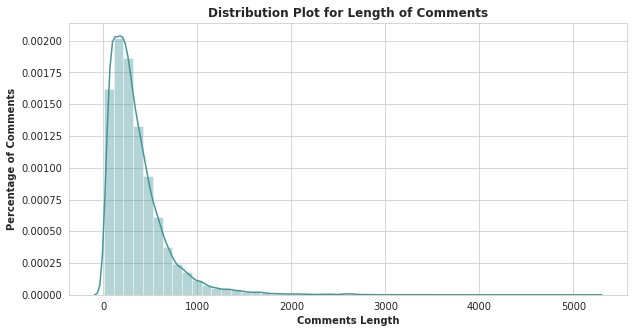

In [174]:
# Plot distribution of the comment length
plt.figure(figsize=(10, 5))
sns.distplot(df_reviews.text_length, kde=True, bins=50, color='#469597')
plt.title('NYC Airbnb Review Lengths Distributin', fontweight="bold")
plt.xlabel('Comments Length', fontweight="bold")
plt.ylabel('Percentage of Comments', fontweight="bold");

In [130]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [131]:
df_reviews.shape

(71648, 6)

In [132]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71648 entries, 0 to 71647
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   listing_id   71648 non-null  int64 
 1   date         71648 non-null  object
 2   reviewer_id  71648 non-null  int64 
 3   comments     71648 non-null  object
 4   language     71648 non-null  object
 5   text_length  71648 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 3.3+ MB


In [ ]:
df_reviews

,listing_id,date,reviewer_id,comments,language,text_length
0,2595,2009-12-10,38960,i ve stayed with my friend at the midtown castle for six days and it was a lovely place to be a big spacious room with a pointy roof which really makes you feel like staying in a castle the location is perfect it is just a few steps from macy s time square and theatre district everything worked just perfect with the keys etc thank you so much jennifer we had a great time in new york attention it s on the floor without a lift but definetely worth it,en,468
1,2595,2010-04-09,71130,we ve been staying here for about nights enjoying to be in the center of the city that never sleeps short ways to everywhere in manhattan by subway or by walk midtown castle is a beauftiful and tastful place jennifer and tori relaxed and friendly hosts thats why we the three berliners recommand that place good to have wifi and a little kitchen too,en,366
2,2595,2010-05-25,117113,we had a wonderful stay at jennifer s charming apartment they were very organized and helpful i would definitely recommend staying at the midtown castle,en,155
3,2595,2012-05-07,1783688,hi to everyone would say our greatest compliments to jennifer the host of midtown castle we spent in this lovely apartment in the heart of manhattan one month april and will remember this time as ours best the apartment is pretty spacious and great located the th ave right around the corner there is everything you can need during your short or long stay jennifer is very friendly vigorous and very responsible host thanks her and highly recomend this apartment for everyone who are looking for a quiet place right in the center of the boiling midtown,en,570
4,2595,2012-05-17,1870771,jennifer was very friendly and helpful and her place is exactly as advertised the location is very convenient and it was a pleasure to stay at the midtown castle i definitely recommend it thanks,en,204
...,...,...,...,...,...,...
71636,72265,2017-06-16,109542482,vanessa was very pleasant and communication was very good,en,58
71637,72265,2017-06-24,1282541,great location close to g train,en,34
71638,72265,2018-04-11,8936723,highly recommend cannot beat this value great location minute walk to subway and sec to bus which connects you easily and quickly to various parts of manhattan and brooklyn organic as well as regular grocery stores and lots of awesome restaurants and stores near by very safe neighborhoods nice room not big but it s plenty enough and everything works well it s nice warm in the winter even though the bedroom is separated by a curtain to the kitchen because the host is mainly in the other section of the apartment you have a lot of privacy vanessa is a very friendly interesting and helpful host,en,626
71639,72265,2018-06-15,17160406,vanessa is a great and very polite host and gives you as much privacy as you want the room can be seen in the photos and has everything you need the location is amazing as well with plenty of bars restaurants and stores around and literally half a block away from g train,en,275


In [175]:
# Tfidfvectorizer computes word counts, idf and tf-idf values all at once
# Compute IDF values (Inverse Document Frequency), weight assigned to each word depending on how commonly used
vectorizer = TfidfVectorizer(min_df=53, max_features=50, stop_words='english', ngram_range=(1,2), use_idf=True)
matrix = vectorizer.fit_transform(df_reviews['comments'])


In [134]:
df_reviews['comments'][0]

'i ve stayed with my friend at the midtown castle for six days and it was a lovely place to be  a big spacious room with a pointy roof  which really makes you feel like staying in a castle  the location is perfect  it is just a few steps from macy s time square and theatre district  everything worked just perfect with the keys etc  thank you so much jennifer  we had a great time in new york  attention  it s on the   floor without a lift     but definetely worth it '

In [135]:
# Display first vector, IDF values for first comment
pd.DataFrame(matrix[0].T.todense(), index=vectorizer.get_feature_names(), 
             columns=["tfidf"]).sort_values(['tfidf'], ascending=False).style.bar(subset=['tfidf'], color=['#5fba7d'])

,tfidf
just,0.438487
perfect,0.408415
time,0.399502
lovely,0.248020
new york,0.245350
york,0.245317
staying,0.237171
like,0.236843
new,0.231466
really,0.204005


### Estimate polarity

**ADER (Valence Aware Dictionary and sentiment Reasoner) Sentiment Analysis**:

It is a lexical database and rule-based sentiment analysis tool that is optimized for social media sentiments. It makes use of a variety of techniques. A sentiment lexicon is a collection of lexical features (e.g., words) that are classified as positive or negative depending on their sentiment polarity. It not only exhibits the Positivity and Negativity scores, but also the degree to which a sentiment is positive or negative <p>

The polarity score() method returns a float for the sentiment strength based on the input text

In [95]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [176]:
# Instantiate SentimentAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [177]:
# Test SentimentAnalyzer on first comment
def sentiment_analyzer(comment):
    polarity_score = analyzer.polarity_scores(comment)
    return(pd.DataFrame.from_dict(polarity_score, orient='index'))

sentiment_analyzer(df_reviews['comments'][0])

,0
neg,0.0000
neu,0.8060
pos,0.1940
compound,0.9274


In [178]:
# Take 'compound' score of the sentiments score
compound_polarity= lambda s: (analyzer.polarity_scores(s))['compound']

In [179]:
# Get compound polarity score of all comments
df_reviews['polarity'] = df_reviews.comments.map(compound_polarity)

In [180]:
df_reviews[:5].style.bar(subset=['polarity'], align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,date,reviewer_id,comments,language,text_length,polarity
0,2595,2009-12-10,38960,i ve stayed with my friend at the midtown castle for six days and it was a lovely place to be a big spacious room with a pointy roof which really makes you feel like staying in a castle the location is perfect it is just a few steps from macy s time square and theatre district everything worked just perfect with the keys etc thank you so much jennifer we had a great time in new york attention it s on the floor without a lift but definetely worth it,en,468,0.927400
1,2595,2010-04-09,71130,we ve been staying here for about nights enjoying to be in the center of the city that never sleeps short ways to everywhere in manhattan by subway or by walk midtown castle is a beauftiful and tastful place jennifer and tori relaxed and friendly hosts thats why we the three berliners recommand that place good to have wifi and a little kitchen too,en,366,0.913600
2,2595,2010-05-25,117113,we had a wonderful stay at jennifer s charming apartment they were very organized and helpful i would definitely recommend staying at the midtown castle,en,155,0.940900
3,2595,2012-05-07,1783688,hi to everyone would say our greatest compliments to jennifer the host of midtown castle we spent in this lovely apartment in the heart of manhattan one month april and will remember this time as ours best the apartment is pretty spacious and great located the th ave right around the corner there is everything you can need during your short or long stay jennifer is very friendly vigorous and very responsible host thanks her and highly recomend this apartment for everyone who are looking for a quiet place right in the center of the boiling midtown,en,570,0.986300
4,2595,2012-05-17,1870771,jennifer was very friendly and helpful and her place is exactly as advertised the location is very convenient and it was a pleasure to stay at the midtown castle i definitely recommend it thanks,en,204,0.954200


In [104]:
df_reviews[df_reviews['polarity']<0][10:15].style.bar(subset=['polarity'], align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,date,reviewer_id,comments,language,text_length,polarity
275,5178,2015-01-20,19127416,lets start with the good part the room is in a great area and there are many great places in walking distance the woman who let us in and was very welcoming and friendly we got tea cocoa a microwave a fridge mugs a toaster and a water boiler to use but the tv didnt work it was way to cold its hardly possible to sleep the bed was not like at the picture it was much worse the host didnt answer me when i had a problem finding the appartment the room was not that clean neither was the bathroom,en,512,-0.595900
283,5178,2015-05-01,14767392,he is very quiet but gave no idea about the area the room was a bit small and the walls and windows are dirty as was the microwave we could not use the kitchen sink as it was blocked good location dave,en,206,-0.665200
293,5178,2015-08-05,6154791,our apartment building in philadelphia caught fire and much of our possessions were ruined and the whole building rendered uninhabitable by water damage the day before i had planned to stay with shunichi so i feel asleep within an hour after arriving at his apartment and didn t wake up until the next morning which goes to show that the room faces a quiet street and that the bed is comfortable even if a metal frame the room is as it looks in the photo with the additions of a table cloth cups mugs and a small mirror without the plant stool and dark full length curtain now replaced by a shorter one that lets the light through it shunichi was very communicative about my move in and had no problem with me coming earlier than i initially indicated nor with me leaving my luggage at his place until i left the city the following day then i crashed out,en,875,-0.851900
311,5178,2015-12-23,48611252,shunichi is a very thoughtful person too bad we didn t spend so much time with him we stayed one night but he planned everything for our stay in the bedroom he prepared for us it was near everything in manhattan especially time square and hell s kitchen it was perfect for our short trip,en,299,-0.078100
362,5178,2017-06-14,133592606,the apartment was in a great location it was four blocks from time square we found a really cool burger place to eat at the air conditioner was the disappointing part of it all we got there before the sun went down and had to leave because it was just that hot in the room no fan was available it was hot in the city and very uncomfortable to sleep this was my first airbnb experience,en,392,-0.102700


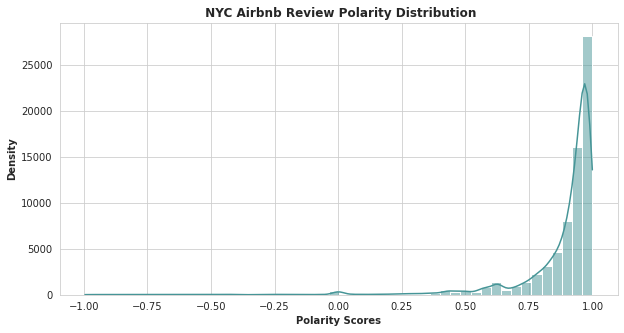

In [237]:
# Plot distribution of the comment length
plt.figure(figsize=(10, 5))
sns.histplot(df_reviews['polarity'], kde=True, bins=50, color='#469597')
plt.title(' NYC Airbnb Review Polarity Distribution', fontweight="bold")
plt.xlabel('Polarity Scores', fontweight="bold")
plt.ylabel('Density', fontweight="bold");

Positive    69754
Neutral      1169
Negative      742
Name: sentiment_type, dtype: int64
------------------------------------------


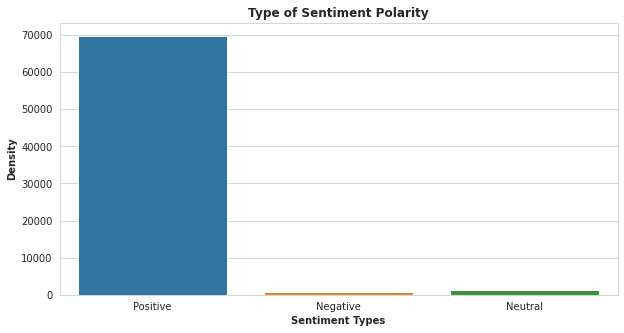

In [185]:
# Identify sentiment type
def sentiment_type(df_reviews):
    if df_reviews['polarity'] > 0:
        val = "Positive"
    elif df_reviews['polarity'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

df_reviews['sentiment_type'] = df_reviews.apply(sentiment_type, axis=1)

print(df_reviews.sentiment_type.value_counts())
print('------------------------------------------')
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
ax = sns.countplot(x="sentiment_type", data=df_reviews)
plt.title('Type of Sentiment Polarity', fontweight="bold")
plt.xlabel('Sentiment Types', fontweight="bold")
plt.ylabel('Density', fontweight="bold");

In [142]:
df_reviews[df_reviews['sentiment_type']=='Neutral'][:20].style.bar(subset=['polarity'],align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,date,reviewer_id,comments,language,text_length,polarity,sentiment_type
38,2595,2019-05-07,168460710,would stay again,en,22,0.000000,Neutral
160,5178,2011-09-08,404983,the host canceled my reservation days before arrival,en,55,0.000000,Neutral
215,5178,2013-02-26,5029546,the reservation was canceled days before arrival this is an automated posting,en,81,0.000000,Neutral
260,5178,2014-08-29,11031194,the reservation was canceled days before arrival this is an automated posting,en,81,0.000000,Neutral
379,5178,2017-10-25,18110000,it is floor there is not an elevador,en,42,0.000000,Neutral
477,5178,2021-07-27,414552453,exactly as advertised,en,22,0.000000,Neutral
552,5203,2012-02-02,1544337,the host canceled my reservation days before arrival,en,55,0.000000,Neutral
883,6848,2017-12-06,16767305,it has a grat location metro just minutes away and you are in minutes in manhatten,en,88,0.000000,Neutral
919,6848,2019-02-17,117326652,polite hosts and a cozy appartment with all amneties,en,53,0.000000,Neutral
1076,6990,2013-12-16,1357842,that s what i call home in ny did i already say it,en,55,0.000000,Neutral


Neutral reviews  mostly includes prototypicals *the host canceled this reservation X days before arrival this is an automated posting*. We can drop this rows

In [203]:
# Drop rows which includes canceled  reservations
df_reviews =  df_reviews[df_reviews["comments"].str.contains("automated")==False]
df_reviews =  df_reviews[df_reviews["comments"].str.contains("canceled")==False]

In [208]:
df_reviews.sentiment_type.value_counts()

Positive    69710
Negative      742
Neutral       388
Name: sentiment_type, dtype: int64

In [206]:
df_reviews[df_reviews['sentiment_type']=='Neutral'][:20].style.bar(subset=['polarity'],align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,date,reviewer_id,comments,language,text_length,polarity,sentiment_type
38,2595,2019-05-07,168460710,would stay again,en,22,0.000000,Neutral
379,5178,2017-10-25,18110000,it is floor there is not an elevador,en,42,0.000000,Neutral
477,5178,2021-07-27,414552453,exactly as advertised,en,22,0.000000,Neutral
883,6848,2017-12-06,16767305,it has a grat location metro just minutes away and you are in minutes in manhatten,en,88,0.000000,Neutral
919,6848,2019-02-17,117326652,polite hosts and a cozy appartment with all amneties,en,53,0.000000,Neutral
1076,6990,2013-12-16,1357842,that s what i call home in ny did i already say it,en,55,0.000000,Neutral
1241,7097,2013-04-28,1316201,epic apartment laden with character stellar backyard fantastically located near fort greene park why would we ever consider a hotel ever again,en,149,0.000000,Neutral
1369,7097,2018-11-24,64651723,not at this time,en,17,0.000000,Neutral
2068,12192,2013-11-28,5611145,small room in big city,en,24,0.000000,Neutral
2600,12940,2013-06-13,93378,not what i expected from the airbnb visuals but serviceable if you need a place to stay close to franklin station this is the place,en,140,0.000000,Neutral


In [209]:
pos_reviews = df_reviews[df_reviews['sentiment_type']=='Positive']

In [210]:
neg_reviews = df_reviews[df_reviews['sentiment_type']=='Negative']

In [211]:
pos_reviews =  ''.join(pos_reviews['comments'])

In [212]:
neg_reviews =  ''.join(neg_reviews['comments'])

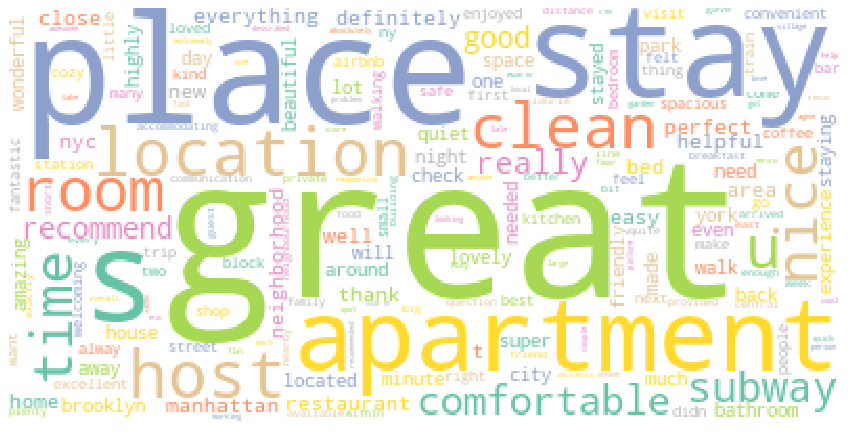

In [234]:
from wordcloud.wordcloud import STOPWORDS
# Plot wordcloud of positive comments
pos_wordcloud = WordCloud(stopwords=set(STOPWORDS), colormap='Set2',collocations=False, mode="RGBA", background_color="white").generate(pos_reviews)

plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(pos_wordcloud, interpolation="None")

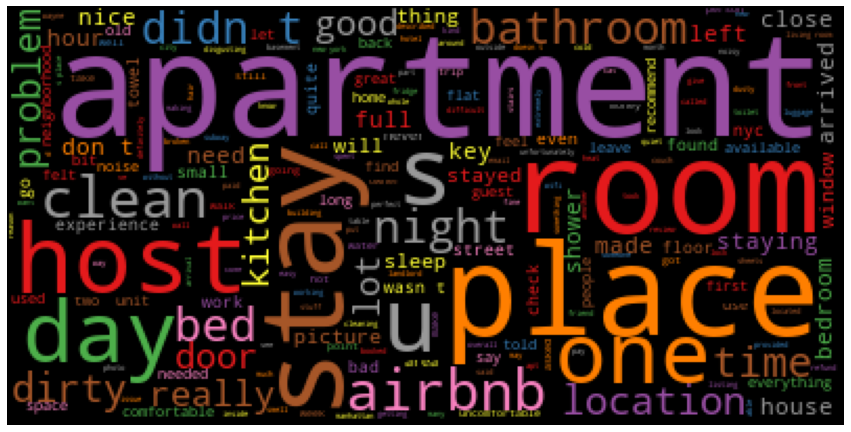

In [236]:
# Plot wordcloud of negative comments
neg_wordcloud = WordCloud(stopwords=set(STOPWORDS),repeat=False, colormap='Set1', background_color="black").generate(neg_reviews)
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(neg_wordcloud)

### Explore Polarity Variable and Correlation with Score Features

In [238]:
# Download listing dataframe
listings = pd.read_csv('/content/listings.csv',low_memory=False);

In [240]:
listings.head()

,id,name,host_name,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,2595,Skylit Midtown Castle,Jennifer,Midtown,Manhattan,40.75356,-73.98559,150.0,4.70,4.72,4.62,4.76,4.79,4.86,4.41
1,5121,BlissArtsSpace!,Garon,Bedford-Stuyvesant,Brooklyn,40.68535,-73.95512,60.0,4.52,4.22,4.09,4.91,4.91,4.47,4.52
2,5136,"Spacious Brooklyn Duplex, Patio + Garden",Rebecca,Sunset Park,Brooklyn,40.66265,-73.99454,275.0,5.00,5.00,5.00,5.00,5.00,4.50,5.00
3,5178,Large Furnished Room Near B'way,Shunichi,Midtown,Manhattan,40.76457,-73.98317,68.0,4.22,4.22,3.74,4.67,4.43,4.87,4.37
4,5203,Cozy Clean Guest Room - Family Apt,MaryEllen,Upper West Side,Manhattan,40.80380,-73.96751,75.0,4.91,4.83,4.82,4.97,4.95,4.94,4.92


In [256]:
df_reviews.head()

,listing_id,date,reviewer_id,comments,language,text_length,polarity,sentiment_type
0,2595,2009-12-10,38960,i ve stayed with my friend at the midtown castle for six days and it was a lovely place to be a big spacious room with a pointy roof which really makes you feel like staying in a castle the location is perfect it is just a few steps from macy s time square and theatre district everything worked just perfect with the keys etc thank you so much jennifer we had a great time in new york attention it s on the floor without a lift but definetely worth it,en,468,0.9274,Positive
1,2595,2010-04-09,71130,we ve been staying here for about nights enjoying to be in the center of the city that never sleeps short ways to everywhere in manhattan by subway or by walk midtown castle is a beauftiful and tastful place jennifer and tori relaxed and friendly hosts thats why we the three berliners recommand that place good to have wifi and a little kitchen too,en,366,0.9136,Positive
2,2595,2010-05-25,117113,we had a wonderful stay at jennifer s charming apartment they were very organized and helpful i would definitely recommend staying at the midtown castle,en,155,0.9409,Positive
3,2595,2012-05-07,1783688,hi to everyone would say our greatest compliments to jennifer the host of midtown castle we spent in this lovely apartment in the heart of manhattan one month april and will remember this time as ours best the apartment is pretty spacious and great located the th ave right around the corner there is everything you can need during your short or long stay jennifer is very friendly vigorous and very responsible host thanks her and highly recomend this apartment for everyone who are looking for a quiet place right in the center of the boiling midtown,en,570,0.9863,Positive
4,2595,2012-05-17,1870771,jennifer was very friendly and helpful and her place is exactly as advertised the location is very convenient and it was a pleasure to stay at the midtown castle i definitely recommend it thanks,en,204,0.9542,Positive


In [249]:
polarity = pd.DataFrame(df_reviews.groupby(['listing_id']).mean()['polarity'])


In [254]:
final_df = pd.concat([polarity,listings], axis=1)

In [255]:
final_df

,polarity,polarity
listing_id,,
2539,0.804388,0.804388
2595,0.801683,0.801683
3831,0.801400,0.801400
5121,0.884436,0.884436
5136,0.986911,0.986911
...,...,...
150804,0.948765,0.948765
150989,0.960839,0.960839
151199,0.894134,0.894134


In [9]:
df_listings.dropna(subset=[ 'review_scores_rating',
                           'review_scores_accuracy',
                           'review_scores_cleanliness', 
                           'review_scores_checkin',
                           'review_scores_communication', 
                           'review_scores_location',
                           'review_scores_value',
                           ],how="any", inplace=True)
                           

NameError: ignored